In [117]:
import matplotlib.pyplot as plt
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path
import math
import scipy.stats as scs


Model a credit-risky portfolio of corporate bonds. Using
the data for 100 counterparties, simulate 1-year losses for each corporate bond, and three sets
of scenarios are generated:
- True distribution: 100000 out-of-sample scenarios (N = 100000 (100000 systemic
scenarios and 1 idiosyncratic scenario for each systemic), non-Normal distribution of
losses)
- Monte Carlo approximation 1: 5000 in-sample scenarios (N = 1000 · 5 = 5000 (1000
systemic scenarios and 5 idiosyncratic scenarios for each systemic), non-Normal
distribution of losses)
- Monte Carlo approximation 2: 5000 in-sample scenarios (N = 5000 (5000 systemic
scenarios and 1 idiosyncratic scenario for each systemic), non-Normal distribution of
losses)

The out-of-sample scenario represents the true distribution of the portfolio loss, while the two
non-Normal datasets are used for evaluating sampling error. VaR and CVaR at 99% and 99.9%
quantile were calculated to evaluate the portfolios and mean loss and standard deviation of
losses were also calculated to evaluate model errors for each corporate bond from the three
scenarios.

The two portfolios are:
- Portfolio 1. One unit invested in each of 100 bonds
- Portfolio 2. Equal value invested in each of 100 bonds

In [72]:
Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')


======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [73]:
# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

In [74]:
len(rho)

50

In [93]:
Ndriver = len(rho)

if Path('losses_out'+'.npz').is_file():
    Losses_out = scipy.sparse.load_npz('losses_out' + '.npz')
else:
    y = np.zeros((Nout,Ndriver)) #100000 scenarios, 50 drivers 100000*50 matrix
    w = np.zeros((Nout,K)) #creditworthiness index, 100000 scenario, 100 counterparties 10000*100 matrix
    cs = np.zeros((Nout,K)) #credit state
    Losses_out = np.zeros((Nout,K)) #loss,  10000 scenarios and 100 counterparties, 10000*100 

    for s in range(1, Nout + 1):
        normal_random = np.random.normal(0,1,(Ndriver,1)) #generating in normal distribution for 50 drivers(observations)
        y[s-1,:]= (np.dot(sqrt_rho,normal_random)).T
        z = np.random.normal(0,1,(K,1)) # generating in normal distribution for 100 counterparties(obserbations)
        # Calculated out-of-sample losses (100000 x 100)
        for k in range(1, 101):
            cd = int(driver[k-1])
            w[s-1,k-1] = beta[k-1]*y[s-1,cd-1] + np.sqrt(1-beta[k-1]**2)*z[k-1]#Compute creditworthiness index
            credit = sorted(np.append(w[s-1,k-1],CS_Bdry[k-1,:])) # Sort credit-state boundaries 
            idx = np.argwhere(credit == w[s-1,k-1]) # find creditworthiness index of counterparty j+1 corresponds to credit-state boundaries
        
            Losses_out[s-1,k-1] = exposure[k-1,idx]


In [76]:
import scipy.stats as scs
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out, rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

#Loss[0] = sorted(np.dot(Losses_out,x0[0]))
#Loss[1] = sorted(np.dot(Losses_out,x0[1]))
for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- #
        Loss = sorted(np.dot(Losses_out,x0[portN]))
        #print(Loss[portN][int(math.ceil(Nout*alf))-1])
        VaRout[portN, q] = Loss[int(math.ceil(Nout*alf))-1]##round up
        VaRinN[portN, q] = np.mean(Loss) + scs.norm.ppf(alf)*np.std(Loss)
        CVaRout[portN, q] = (1/(Nout*(1-alf)))*((math.ceil(Nout*alf) - Nout*alf)*VaRout[portN, q]+sum(Loss[int(math.ceil(Nout*alf)):]))
        CVaRinN[portN, q] = np.mean(Loss)+(scs.norm.pdf(scs.norm.ppf(alf))/(1-alf))*np.std(Loss)


In [109]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)


for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 1

    y_MC1 = np.zeros((np.int(Nin/Ns),Ndriver))
    w_MC1 = np.zeros((np.int(np.ceil(Nin/Ns)),Ns,K)) #index
    Losses_MC1 = np.zeros((Nin,K)) #loss
    
    
    for s in range(1, np.int(np.ceil(Nin/Ns) + 1)): # systemic scenarios
        normal_random = np.random.normal(0,1,(Ndriver,1)) #generating in normal distribution for 50 drivers(observations)
        y_MC1[s-1,:]= (np.dot(sqrt_rho,normal_random)).T
        
        
        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic
            z_MC1 = np.random.normal(0,1,(K,1))
            
            for k in range(1, 101):
                cd= driver[k-1].astype(int)
                w_MC1[s-1,si-1,k-1] = beta[k-1]*y_MC1[s-1,cd-1]+np.sqrt(1-beta[k-1]**2)*z_MC1[k-1]
                credit = sorted(np.append(w_MC1[s-1,si-1,k-1],CS_Bdry[k-1,:]))
                idx = np.argwhere(credit == w_MC1[s-1,si-1,k-1])
                
                Losses_MC1[5*(s-1)+si-1,k-1] = exposure[k-1,idx]
                
                
                
    # Monte Carlo approximation 2
    
    y_MC2 = np.zeros((Nin,Ndriver))
    w_MC2 = np.zeros((Nin,K)) #index
    Losses_MC2 = np.zeros((Nin,K)) #loss

    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
    
        normal_random = np.random.normal(0,1,(Ndriver,1)) #generating in normal distribution for 50 drivers(observations)
        y_MC2[s-1,:]= (np.dot(sqrt_rho,normal_random)).T
        z_MC2 = np.random.normal(0,1,(K,1))
            
        for k in range(1, 101):
                cd= driver[k-1].astype(int)
                w_MC2[s-1,k-1] = beta[k-1]*y_MC2[s-1,cd-1]+np.sqrt(1-beta[k-1]**2)*z_MC2[k-1]
                credit = sorted(np.append(w_MC2[s-1,k-1],CS_Bdry[k-1,:]))
                idx = np.argwhere(credit == w_MC2[s-1,k-1])
                
                Losses_MC2[s-1,k-1] = exposure[k-1,idx]
    
    
    
    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # Compute portfolio loss
            portf_loss_inMC1 = sorted(np.dot(Losses_MC1, x0[portN]))
            portf_loss_inMC2 = sorted(np.dot(Losses_MC2, x0[portN]))
            mu_MC1 = np.mean(Losses_MC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_MC1, rowvar=False)
            mu_MC2 = np.mean(Losses_MC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_MC2, rowvar=False)
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            # Compute VaR and CVaR for the current trial
            mu_p_MC1 = np.dot(mu_MC1,x0[portN])
            sigma_p_MC1 = np.std(portf_loss_inMC1)
            mu_p_MC2 = np.dot(mu_MC2,x0[portN])
            sigma_p_MC2 = np.std(portf_loss_inMC2)
            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin*alf)) -1]
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin*alf)) -1]
            VaRinN1[portN, q][tr - 1] =  mu_p_MC1 + scs.norm.ppf(alf)*sigma_p_MC1
            VaRinN2[portN, q][tr - 1] =  mu_p_MC2 + scs.norm.ppf(alf)*sigma_p_MC2
            CVaRinMC1[portN, q][tr - 1] = (1/(Nin*(1-alf)))*((math.ceil(Nin*alf)-Nin*alf)*VaRinMC1[portN, q][tr-1] + sum(portf_loss_inMC1[int(math.ceil(Nin*alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1/(Nin*(1-alf)))*((math.ceil(Nin*alf)-Nin*alf)*VaRinMC2[portN, q][tr-1] + sum(portf_loss_inMC2[int(math.ceil(Nin*alf)):]))
            CVaRinN1[portN, q][tr - 1] =  mu_p_MC1+(scs.norm.pdf(scs.norm.ppf(alf))/(1-alf))*sigma_p_MC1
            CVaRinN2[portN, q][tr - 1] =  mu_p_MC2+(scs.norm.pdf(scs.norm.ppf(alf))/(1-alf))*sigma_p_MC2

In [110]:
# show VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


Portfolio 1:

Out-of-sample: VaR 99.0% = $37129437.78, CVaR 99.0% = $44875329.64
In-sample MC1: VaR 99.0% = $37120238.25, CVaR 99.0% = $44620857.69
In-sample MC2: VaR 99.0% = $37167225.60, CVaR 99.0% = $44663672.65
In-sample No: VaR 99.0% = $26097736.07, CVaR 99.0% = $28980629.58
In-sample N1: VaR 99.0% = $26201448.38, CVaR 99.0% = $29090780.57
In-sample N2: VaR 99.0% = $26151902.65, CVaR 99.0% = $29035834.62

Out-of-sample: VaR 99.9% = $55616282.60, CVaR 99.9% = $62638159.52
In-sample MC1: VaR 99.9% = $54020428.80, CVaR 99.9% = $60957708.85
In-sample MC2: VaR 99.9% = $53883103.46, CVaR 99.9% = $61688828.55
In-sample No: VaR 99.9% = $32596455.97, CVaR 99.9% = $34951813.70
In-sample N1: VaR 99.9% = $32714682.59, CVaR 99.9% = $35075300.80
In-sample N2: VaR 99.9% = $32652963.50, CVaR 99.9% = $35009169.67


Portfolio 2:

Out-of-sample: VaR 99.0% = $27344072.93, CVaR 99.0% = $33609854.21
In-sample MC1: VaR 99.0% = $27344472.80, CVaR 99.0% = $33370235.24
In-sample MC2: VaR 99.0% = $27415049

In [195]:
pd.options.display.float_format = '${:,.3f}'.format
#portfolio 1
print('Portfolio 1')
df1 = pd.DataFrame([[VaRout[0, 0],CVaRout[0, 0], VaRout[0, 1],CVaRout[0, 1]],
                      [np.mean(VaRinMC1[0, 0]),np.mean(CVaRinMC1[0, 0]), np.mean(VaRinMC1[0, 1]),np.mean(CVaRinMC1[0, 1])],
                      [np.mean(VaRinMC2[0, 0]),np.mean(CVaRinMC2[0, 0]), np.mean(VaRinMC2[0, 1]),np.mean(CVaRinMC2[0, 1])], 
                      [VaRinN[0, 0],CVaRinN[0, 0], VaRinN[0, 1],CVaRinN[0, 1]],
                      [np.mean(VaRinN1[0, 0]),np.mean(CVaRinN1[0, 0]), np.mean(VaRinN1[0, 1]),np.mean(CVaRinN1[0, 1])],
                      [np.mean(VaRinN2[0, 0]),np.mean(CVaRinN2[0, 0]), np.mean(VaRinN2[0, 1]),np.mean(CVaRinN2[0, 1])]
                     ], 
                      index = ['out of sample','In Sample MC1', 'In Smaple MC2', 'In Sample No', 'In Sample N1', 'In Sample N2'],
            columns=['99% VaR','99%CVaR', '99.9% VAR', '99.9% CVAR'])
df1

Portfolio 1


,99% VaR,99%CVaR,99.9% VAR,99.9% CVAR
out of sample,"$37,129,437.780","$44,875,329.642","$55,616,282.600","$62,638,159.515"
In Sample MC1,"$37,120,238.251","$44,620,857.687","$54,020,428.798","$60,957,708.854"
In Smaple MC2,"$37,167,225.600","$44,663,672.647","$53,883,103.456","$61,688,828.546"
In Sample No,"$26,097,736.072","$28,980,629.576","$32,596,455.968","$34,951,813.700"
In Sample N1,"$26,201,448.384","$29,090,780.572","$32,714,682.588","$35,075,300.801"
In Sample N2,"$26,151,902.646","$29,035,834.620","$32,652,963.499","$35,009,169.674"


In [196]:
SE = (df1.iloc[1] - df1.iloc[0])/df1.iloc[0]
SE

99% VaR      $-0.000
99%CVaR      $-0.006
99.9% VAR    $-0.029
99.9% CVAR   $-0.027
dtype: float64

In [198]:
#portfolio 2
print('Portfolio 2')
df2 = pd.DataFrame([[VaRout[1, 0],CVaRout[1, 0], VaRout[1, 1],CVaRout[1, 1]],
                      [np.mean(VaRinMC1[1, 0]),np.mean(CVaRinMC1[1, 0]), np.mean(VaRinMC1[1, 1]),np.mean(CVaRinMC1[1, 1])],
                      [np.mean(VaRinMC2[1, 0]),np.mean(CVaRinMC2[1, 0]), np.mean(VaRinMC2[1, 1]),np.mean(CVaRinMC2[1, 1])], 
                      [VaRinN[1, 0],CVaRinN[1, 0], VaRinN[1, 1],CVaRinN[1, 1]],
                      [np.mean(VaRinN1[1, 0]),np.mean(CVaRinN1[1, 0]), np.mean(VaRinN1[1, 1]),np.mean(CVaRinN1[1, 1])],
                      [np.mean(VaRinN2[1, 0]),np.mean(CVaRinN2[1, 0]), np.mean(VaRinN2[1, 1]),np.mean(CVaRinN2[1, 1])]
                     ], 
                      index = ['out of sample','In Sample MC1', 'In Smaple MC2', 'In Sample No', 'In Sample N1', 'In Sample N2'],
            columns=['99% VaR','99%CVaR', '99.9% VAR', '99.9% CVAR'])
df2

Portfolio 2


,99% VaR,99%CVaR,99.9% VAR,99.9% CVAR
out of sample,"$27,344,072.927","$33,609,854.214","$41,675,233.256","$48,057,116.112"
In Sample MC1,"$27,344,472.798","$33,370,235.244","$40,858,018.393","$46,915,567.762"
In Smaple MC2,"$27,415,049.897","$33,636,075.552","$41,462,831.615","$48,017,106.856"
In Sample No,"$21,000,641.696","$23,158,323.802","$25,864,564.562","$27,627,416.096"
In Sample N1,"$21,079,110.981","$23,241,909.053","$25,954,566.436","$27,721,597.773"
In Sample N2,"$21,122,319.098","$23,290,351.030","$26,009,572.906","$27,780,880.369"


## plot

1. Portfolio 1

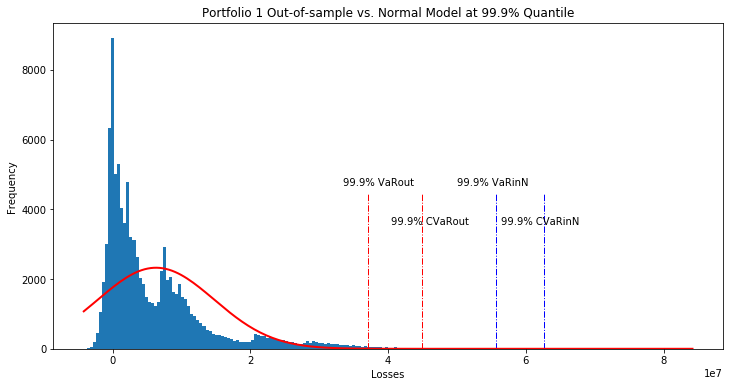

In [158]:
#out sample
plt.figure(figsize=(12,6))

count, bins, patches = plt.hist(np.dot(Losses_out,x0[0]), 200)
normf= (1/(np.std(np.dot(Losses_out,x0[0]))*math.sqrt(2*math.pi)))*np.exp(-0.5*((bins-np.mean(np.dot(Losses_out,x0[0]))) / np.std(np.dot(Losses_out,x0[0])))**2)

plt.plot([VaRout[0,0], VaRout[0,0]], [0, max(count)/2], color='r', linewidth=1, linestyle='-.')#99
plt.plot([VaRout[0,1], VaRout[0,1]], [0, max(count)/2], color='b', linewidth=1, linestyle='-.')#99.9
plt.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(count)/2], color='r', linewidth=1, linestyle='-.')#99
plt.plot([CVaRout[0,1], CVaRout[0,1]], [0, max(count)/2], color='b', linewidth=1, linestyle='-.')#99.9
plt.plot(bins, normf*sum(count)/sum(normf), color='r', linewidth=2.0)

plt.text(0.9*VaRout[0,0], max(count)/1.9, '99.9% VaRout')
plt.text(0.9*VaRout[0,1], max(count)/1.9, '99.9% VaRinN')
plt.text(0.9*CVaRout[0,0], max(count)/2.5, '99.9% CVaRout')
plt.text(0.9*CVaRout[0,1], max(count)/2.5, '99.9% CVaRinN')
plt.title('Portfolio 1 Out-of-sample vs. Normal Model at 99.9% Quantile')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

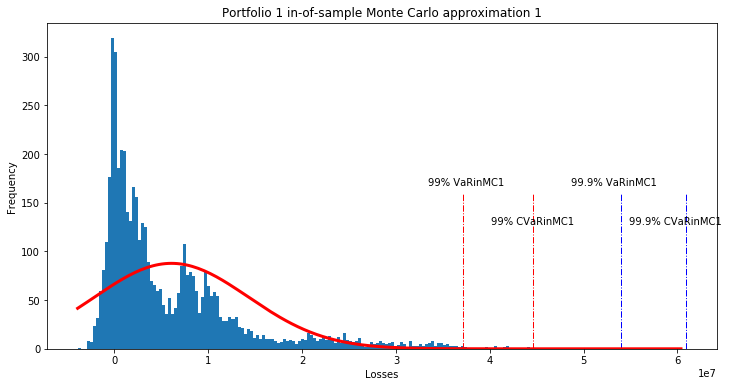

In [120]:
#Simulation 1

plt.figure(figsize=(12,6))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_MC1,x0[0]), 200)
normf= (1/(np.std(np.dot(Losses_MC1,x0[0]))*math.sqrt(2*math.pi))) * np.exp(-0.5*((binLocations-np.mean(np.dot(Losses_MC1,x0[0])))/np.std(np.dot(Losses_MC1,x0[0])))**2)


plt.plot([np.mean(VaRinMC1[0,0]), np.mean(VaRinMC1[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinMC1[0,1]), np.mean(VaRinMC1[0,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[0,0]), np.mean(CVaRinMC1[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[0,1]), np.mean(CVaRinMC1[0,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf * sum(frequencyCounts)/sum(normf), color='r', linewidth=3.0)

plt.text(0.9*np.mean(VaRinMC1[0,0]), max(frequencyCounts)/1.9, '99% VaRinMC1')
plt.text(0.9*np.mean(VaRinMC1[0,1]), max(frequencyCounts)/1.9, '99.9% VaRinMC1')
plt.text(0.9*np.mean(CVaRinMC1[0,0]), max(frequencyCounts)/2.5, '99% CVaRinMC1')
plt.text(0.9*np.mean(CVaRinMC1[0,1]), max(frequencyCounts)/2.5, '99.9% CVaRinMC1')
plt.title('Portfolio 1 in-of-sample Monte Carlo approximation 1')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

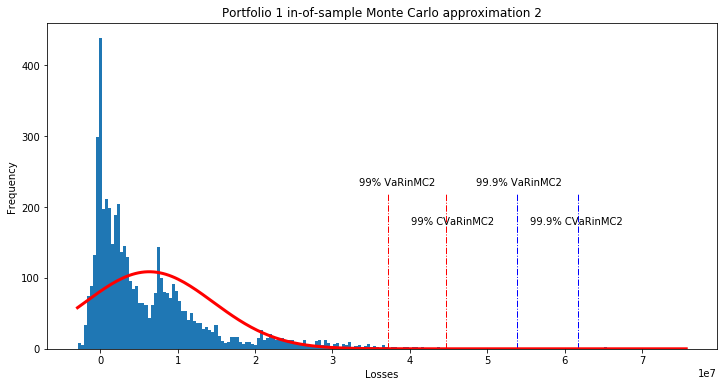

In [121]:
#Simulation 2
plt.figure(figsize=(12,6))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_MC2,x0[0]), 200)
normf= (1/(np.std(np.dot(Losses_MC2,x0[0]))*math.sqrt(2*math.pi)))*np.exp(-0.5*((binLocations-np.mean(np.dot(Losses_MC2,x0[0])))/np.std(np.dot(Losses_MC2,x0[0])))**2)

plt.plot([np.mean(VaRinMC2[0,0]), np.mean(VaRinMC2[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')#99
plt.plot([np.mean(VaRinMC2[0,1]), np.mean(VaRinMC2[0,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')#99.9
plt.plot([np.mean(CVaRinMC2[0,0]), np.mean(CVaRinMC2[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')#99
plt.plot([np.mean(CVaRinMC2[0,1]), np.mean(CVaRinMC2[0,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')#99.9
plt.plot(binLocations,normf * sum(frequencyCounts)/sum(normf), color='r', linewidth=3.0)

plt.text(0.9*np.mean(VaRinMC2[0,0]), max(frequencyCounts)/1.9, '99% VaRinMC2')
plt.text(0.9*np.mean(VaRinMC2[0,1]), max(frequencyCounts)/1.9, '99.9% VaRinMC2')
plt.text(0.9*np.mean(CVaRinMC2[0,0]), max(frequencyCounts)/2.5, '99% CVaRinMC2')
plt.text(0.9*np.mean(CVaRinMC2[0,1]), max(frequencyCounts)/2.5, '99.9% CVaRinMC2')
plt.title('Portfolio 1 in-of-sample Monte Carlo approximation 2')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()


## Plot

2. Portfolio 2

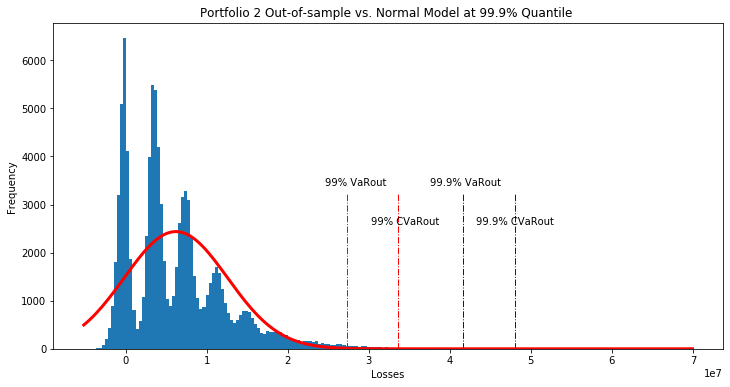

In [122]:
#out sample
plt.figure(figsize=(12,6))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_out,x0[1]), 200)
normf= (1/(np.std(np.dot(Losses_out,x0[1]))*math.sqrt(2*math.pi)))*np.exp(-0.5*((binLocations-np.mean(np.dot(Losses_out,x0[1])))/np.std(np.dot(Losses_out,x0[1])))**2)


plt.plot([VaRout[1,0], VaRout[1,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([VaRout[1,1], VaRout[1,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([CVaRout[1,0], CVaRout[1,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRout[1,1], CVaRout[1,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf * sum(frequencyCounts)/sum(normf), color='r', linewidth=3.0)

plt.text(0.9*VaRout[1,0], max(frequencyCounts)/1.9, '99% VaRout')
plt.text(0.9*VaRout[1,1], max(frequencyCounts)/1.9, '99.9% VaRout')
plt.text(0.9*CVaRout[1,0], max(frequencyCounts)/2.5, '99% CVaRout')
plt.text(0.9*CVaRout[1,1], max(frequencyCounts)/2.5, '99.9% CVaRout')
plt.title('Portfolio 2 Out-of-sample vs. Normal Model at 99.9% Quantile ')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

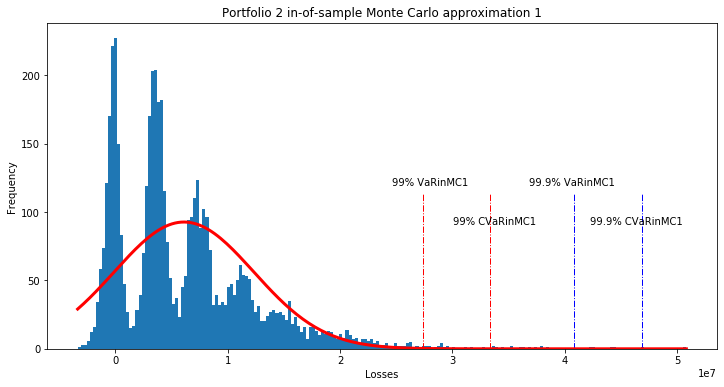

In [123]:
# simulation 1
plt.figure(figsize=(12,6))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_MC1,x0[1]), 200)

normf= (1/(np.std(np.dot(Losses_MC1,x0[1]))*math.sqrt(2*math.pi)))*np.exp(-0.5*((binLocations-np.mean(np.dot(Losses_MC1,x0[1])))/np.std(np.dot(Losses_MC1,x0[1])))**2)

plt.plot([np.mean(VaRinMC1[1,0]), np.mean(VaRinMC1[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinMC1[1,1]), np.mean(VaRinMC1[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[1,0]), np.mean(CVaRinMC1[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[1,1]), np.mean(CVaRinMC1[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations,normf * sum(frequencyCounts)/sum(normf), color='r', linewidth=3.0)

plt.text(0.9*np.mean(VaRinMC1[1,0]), max(frequencyCounts)/1.9, '99% VaRinMC1')
plt.text(0.9*np.mean(VaRinMC1[1,1]), max(frequencyCounts)/1.9, '99.9% VaRinMC1')
plt.text(0.9*np.mean(CVaRinMC1[1,0]), max(frequencyCounts)/2.5, '99% CVaRinMC1')
plt.text(0.9*np.mean(CVaRinMC1[1,1]), max(frequencyCounts)/2.5, '99.9% CVaRinMC1')
plt.title('Portfolio 2 in-of-sample Monte Carlo approximation 1')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()


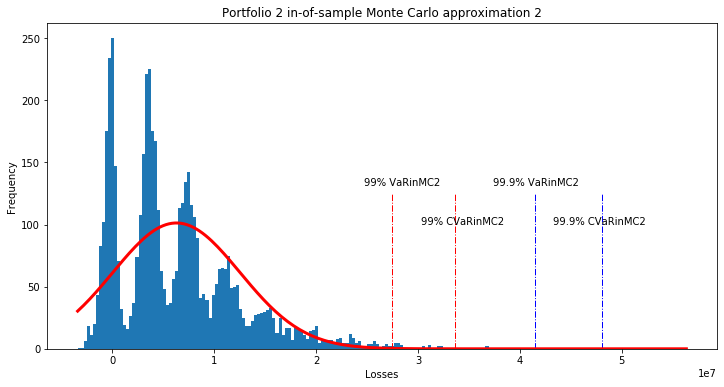

In [124]:
#simulation 2
plt.figure(figsize=(12,6))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_MC2,x0[1]), 200)
normf= (1/(np.std(np.dot(Losses_MC2,x0[1]))*math.sqrt(2*math.pi)))*np.exp(-0.5*((binLocations-np.mean(np.dot(Losses_MC2,x0[1])))/np.std(np.dot(Losses_MC2,x0[1])))**2)

plt.plot([np.mean(VaRinMC2[1,0]), np.mean(VaRinMC2[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinMC2[1,1]), np.mean(VaRinMC2[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[1,0]), np.mean(CVaRinMC2[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[1,1]), np.mean(CVaRinMC2[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations,normf * sum(frequencyCounts)/sum(normf), color='r', linewidth=3.0)

plt.text(0.9*np.mean(VaRinMC2[1,0]), max(frequencyCounts)/1.9, '99% VaRinMC2')
plt.text(0.9*np.mean(VaRinMC2[1,1]), max(frequencyCounts)/1.9, '99.9% VaRinMC2')
plt.text(0.9*np.mean(CVaRinMC2[1,0]), max(frequencyCounts)/2.5, '99% CVaRinMC2')
plt.text(0.9*np.mean(CVaRinMC2[1,1]), max(frequencyCounts)/2.5, '99.9% CVaRinMC2')
plt.title('Portfolio 2 in-of-sample Monte Carlo approximation 2')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

# Mean, Standard Deviation

In [194]:
#####portfolio 1
# outesample
loss_1 = sorted(np.dot(Losses_out,x0[0]))
mean_loss_1 = np.mean(loss_1)
std_loss_1 = np.std(loss_1)


# simulation 1
mc1_loss_1 = sorted(np.dot(Losses_MC1,x0[0]))
mc1_mean_loss_1 = np.dot(mu_MC1,x0[0])
mc1_std_loss_1 = np.std(mc1_loss_1)

# simulation 2
mc2_loss_1 = sorted(np.dot(Losses_MC2,x0[0]))
mc2_mean_loss_1 = np.dot(mu_MC2,x0[0])
mc2_std_loss_1 = np.std(mc2_loss_1)


print('portfolio 1:')
print('out-sample mean:', mean_loss_1, 'out sample standard deviation', std_loss_1 )
print('simulation 1 mean:',mc1_mean_loss_1, 'simulation 1 standard deviation', mc1_std_loss_1 )
print('simulation 2 mean:',mc2_mean_loss_1, 'simulation 1 standard deviation', mc2_std_loss_1 )

###### portfolio 2
# out sample
loss_2 = sorted(np.dot(Losses_out,x0[1]))
mean_loss_2 = np.mean(loss_2)
std_loss_2 = np.std(loss_2)


#simulation 1
mc1_loss_2 = sorted(np.dot(Losses_MC2,x0[1]))
mc1_mean_loss_2 = np.dot(mu_MC1,x0[1])
mc1_std_loss_2 = np.std(mc1_loss_2)


# simulation 2
mc2_loss_2 = sorted(np.dot(Losses_MC2,x0[1]))
mc2_mean_loss_2 = np.dot(mu_MC2,x0[1])
mc2_std_loss_2 = np.std(mc2_loss_2)

print('')
print('portfolio 2:')
print('out-sample mean:', mean_loss_2, 'out sample standard deviation', std_loss_2 )
print('simulation 1 mean:',mc1_mean_loss_2, 'simulation 1 standard deviation', mc1_std_loss_2 )
print('simulation 2 mean:',mc2_mean_loss_2, 'simulation 1 standard deviation', mc2_std_loss_2 )

portfolio 1:
out-sample mean: 6308084.428786201 out sample standard deviation 8443726.745473668
simulation 1 mean: 6083353.154503984 simulation 1 standard deviation 8184969.119932312
simulation 2 mean: 6326560.065623991 simulation 1 standard deviation 8259238.7602562895

portfolio 2:
out-sample mean: 6208990.0389566915 out sample standard deviation 6365506.952072324
simulation 1 mean: 6098473.13066634 simulation 1 standard deviation 6239770.070209354
simulation 2 mean: 6298451.37465984 simulation 1 standard deviation 6239770.070209354
